In [20]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score


In [ ]:
# 1. Load the data
df = pd.read_csv("/data/star_classification.csv")  # change path if needed

# 2. Drop irrelevant columns
df = df.drop(columns=["obj_ID", "run_ID", "rerun_ID", "cam_col", "field_ID", "spec_obj_ID"])

# # 3. Create color indices (new features)
# df["u_g"] = df["u"] - df["g"]
# df["g_r"] = df["g"] - df["r"]
# df["r_i"] = df["r"] - df["i"]
# df["i_z"] = df["i"] - df["z"]

In [35]:
import pandas as pd

# Assuming your full dataset is in a DataFrame called df
# And the target column is named 'class' (change if needed)

# Separate by class
galaxy_df = df[df['class'] == 'GALAXY'].sample(n=18961, random_state=42)
star_df   = df[df['class'] == 'STAR'].sample(n=18961, random_state=42)
qso_df    = df[df['class'] == 'QSO']  # Keep all QSOs

# Combine into one balanced DataFrame
df = pd.concat([galaxy_df, star_df, qso_df]).sample(frac=1, random_state=42).reset_index(drop=True)


In [36]:
X = df.drop(columns=["class"])
y = df["class"]

# 5. Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 6. Scale features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
# 7. Grid Search - Random Forest
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [10]
    
}

grid_rf = GridSearchCV(
    RandomForestClassifier(class_weight='balanced',random_state=42),
    param_grid_rf,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)
grid_rf.fit(X_train, y_train)



Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10], 'n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

In [38]:
# 8. Grid Search - SVM
param_grid_svm = {
    "C": [1, 10],
    "gamma": ["scale"],
    "kernel": ["rbf"]
}

grid_svm = GridSearchCV(
    SVC(class_weight='balanced'),
    param_grid_svm,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)
grid_svm.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': [1, 10], 'gamma': ['scale'], 'kernel': ['rbf']},
             scoring='accuracy')

In [39]:
# 9. Evaluate both
rf_pred = grid_rf.best_estimator_.predict(X_test)
svm_pred = grid_svm.best_estimator_.predict(X_test_scaled)

print("📊 Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

print("📊 SVM Results:")
print("Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))

print("✅ Best RF Params:", grid_rf.best_params_)
print("✅ Best SVM Params:", grid_svm.best_params_)

📊 Random Forest Results:
Accuracy: 0.9732786404922356
              precision    recall  f1-score   support

      GALAXY       0.95      0.97      0.96      5688
         QSO       0.97      0.95      0.96      5688
        STAR       0.99      1.00      1.00      5689

    accuracy                           0.97     17065
   macro avg       0.97      0.97      0.97     17065
weighted avg       0.97      0.97      0.97     17065

📊 SVM Results:
Accuracy: 0.9627307354233812
              precision    recall  f1-score   support

      GALAXY       0.93      0.96      0.95      5688
         QSO       0.98      0.93      0.95      5688
        STAR       0.98      1.00      0.99      5689

    accuracy                           0.96     17065
   macro avg       0.96      0.96      0.96     17065
weighted avg       0.96      0.96      0.96     17065

✅ Best RF Params: {'max_depth': 10, 'n_estimators': 200}
✅ Best SVM Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [40]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=rf_pred)


<Axes: >

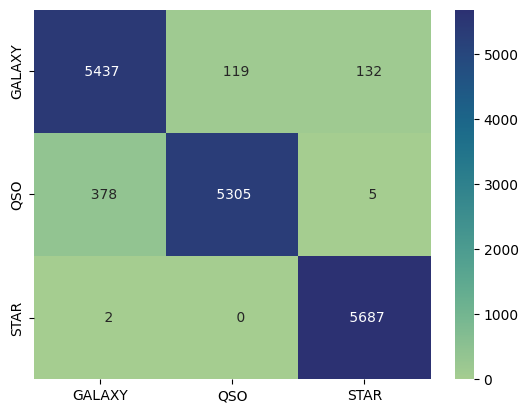

In [45]:
sns.heatmap(cm, annot=cm, fmt='5d', xticklabels=grid_rf.classes_, yticklabels=grid_rf.classes_, cmap='crest')

In [42]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=svm_pred)

<Axes: >

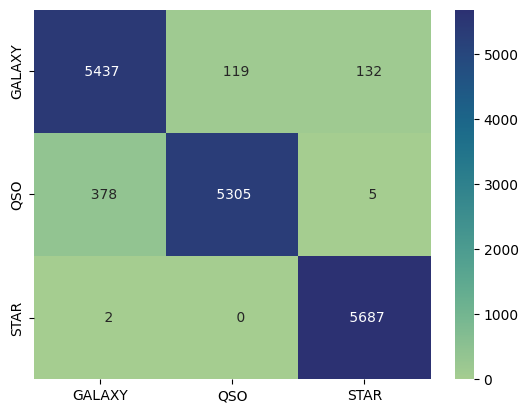

In [46]:
sns.heatmap(cm, annot=True,fmt='5d', xticklabels=grid_svm.classes_, yticklabels=grid_svm.classes_, cmap='crest')